## Import dependencies

In [1]:
import torch
from torch import nn

from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from time import time
from tqdm.auto import tqdm
import os

## Set up device-agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load the data

In [6]:
module_dir = Path('modules')
if not module_dir.is_dir():
  os.mkdir(module_dir)

In [7]:
%%writefile modules/data_setup.py
"""
Contains functionality to create PyTorch DataLoaders
from the CIFAR-10 dataset
"""
from pathlib import Path
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import os

def get_cifar10_dataloaders(data_dir: str,
                            transform: transforms.Compose,
                            batch_size: int=32,
                            num_workers: int=os.cpu_count()):
  """
  Prepare DataLoader objects for the CIFAR-10 dataset

  Args:
  - data_dir (str): The directory where the CIFAR-10 dataset will be stored.
  - transform (torchvision.transforms.transforms.Compose): A composition of image transformations to apply to the dataset.
  - batch_size (int, optional): Number of samples per batch to load (default is 32).
  - num_workers (int, optional): Number of subprocesses to use for data loading (default is the number of CPU cores).

  Returns:
  - train_dataloader (torch.utils.data.DataLoader): DataLoader object for the training data.
  - test_dataloader (torch.utils.data.DataLoader): DataLoader object for the test data.
  - class_names (list): A list of class names present in the CIFAR-10 dataset.

  The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
    This function loads the CIFAR-10 dataset from the specified `data_dir`, applies the specified `transformations`,
    and creates DataLoader objects for both the training and test datasets. The training DataLoader shuffles the data,
    while the test DataLoader does not shuffle the data.

  Example:
  ```python
  import torchvision.transforms as transforms

  # Define transformations
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
  ])

  # Get dataloaders
  train_dataloader, test_dataloader, class_names = get_cifar10_dataloaders(
      data_dir='/path/to/your/CIFAR-10/dataset',
      transform=transform,
      batch_size=32,
      num_workers=4
  )
  ```
  """
  # Set up the path for root directory
  data_dir = Path(data_dir)

  # Get the training data
  train_data = CIFAR10(root=data_dir,
                       train=True,
                       transform=transform,
                       target_transform=None,
                       download=True)

  # Get the test data
  test_data = CIFAR10(root=data_dir,
                      train=False,
                      transform=transform,
                      target_transform=None,
                      download=True)

  # Get the class names in a list
  class_names = train_data.classes

  # Prepare the training dataloader
  train_dataloader = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers)

  # Prepare the test dataloader
  test_dataloader = DataLoader(dataset=test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers)

  return train_dataloader, test_dataloader, class_names

Writing modules/data_setup.py


In [4]:
# Set up the data directory path
data_dir = Path('data/')
data_dir

PosixPath('data')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Get the training data
train_data = datasets.CIFAR10(root=data_dir,
                              train=True,
                              transform=transform,
                              target_transform=None,
                              download=True)

# Get the test data
test_data = datasets.CIFAR10(root=data_dir,
                             train=False,
                             transform=transform,
                             target_transform=None,
                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_data), len(test_data)

(50000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Visualize what we're working

In [ ]:
image, label = train_data[0]

image, label

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

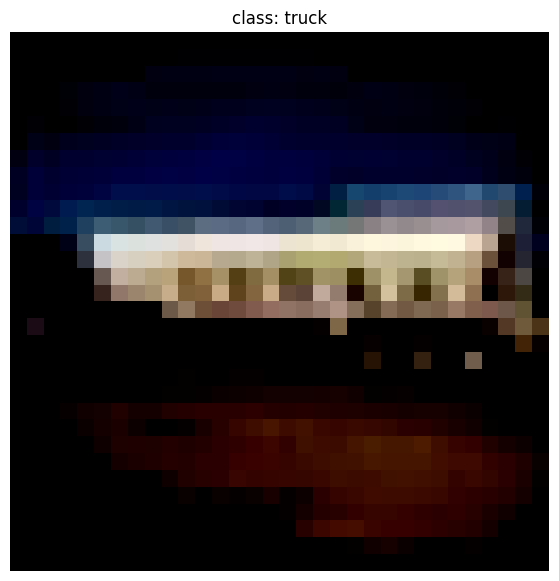

In [ ]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
image, label = train_data[random_idx]

plt.figure(figsize=(10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.title(f'class: {class_names[label]}')
plt.axis(False)
plt.show()

## Prepare DataLoaders

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))

## Build a baseline model

In [ ]:
class CIFAR10ModelV0(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=16),
        nn.Linear(in_features=16, out_features=output_shape)
    )

  def forward(self, X: torch.Tensor):
    return self.layer_stack(X)

In [ ]:
model_0 = CIFAR10ModelV0(input_shape=3*32*32,
                         output_shape=len(class_names)).to(device)
model_0

CIFAR10ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3)

In [8]:
%%writefile modules/accuracy.py
"""
Contains functionality to calculate the accuracy score.
"""
import torch

def accuracy_fn(y_true, y_pred):
  correct = torch.sum(torch.eq(y_true, y_pred))
  total = len(y_true)

  return correct / total

Writing modules/accuracy.py


In [ ]:
epochs = 3
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

for epoch in range(epochs):
  # Training
  model_0.train()
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(axis=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Testing
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model_0(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(axis=1))
      test_acc += acc

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Training loss: {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

Training loss: 1.897058367729187 | Training accuracy: 0.32465609908103943 | Test loss: 1.8640395402908325 | Test accuracy: 0.3399560749530792
Training loss: 1.8075158596038818 | Training accuracy: 0.36227184534072876 | Test loss: 1.7824989557266235 | Test accuracy: 0.3833744525909424
Training loss: 1.7858387231826782 | Training accuracy: 0.37707120180130005 | Test loss: 1.8216841220855713 | Test accuracy: 0.36444368958473206


In [10]:
%%writefile modules/engine.py
"""
Contains functionality to train and test a model.
"""

import torch
from accuracy import accuracy_fn

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          accuracy_fn=accuracy_fn):
  train_loss, train_acc = 0, 0

  model.to(device)
  model.train()
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(axis=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         accuracy_fn=accuracy_fn):
  test_loss, test_acc = 0, 0

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(axis=1))
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

Overwriting modules/engine.py


In [ ]:
epochs = 3


for epoch in range(epochs):
  # Training
  train_loss, train_acc = train(model=model_0,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                accuracy_fn=accuracy_fn)

  # Testing
  test_loss, test_acc = test(model=model_0,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             device=device,
                             accuracy_fn=accuracy_fn)

  print(f'Training loss: {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

Training loss: 1.7701835632324219 | Training accuracy: 0.38131797313690186 | Test loss: 1.763895869255066 | Test accuracy: 0.3850838541984558
Training loss: 1.7598764896392822 | Training accuracy: 0.38667625188827515 | Test loss: 1.761643886566162 | Test accuracy: 0.37390175461769104
Training loss: 1.751365303993225 | Training accuracy: 0.39169466495513916 | Test loss: 1.757739543914795 | Test accuracy: 0.38039135932922363


In [11]:
%%writefile modules/model_builder.py
"""
Contains functionality to fit a model
to the given data and track the loss and accuracy for each epoch.
"""
import torch
from accuracy import accuracy_fn

def fit(model: torch.nn.Module,
        epochs: int,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device=device,
        accuracy_fn=accuracy_fn,
        patience: int=5,
        min_delta: float=0.001,
        wait: int=0):
  history = {
      'train_losses': [],
      'train_accuracies': [],
      'test_losses': [],
      'test_accuracies': [],
  }

  best_loss = np.Inf
  best_state_dict = model.state_dict()

  start_time = time()

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model=model,
                                  dataloader=train_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  device=device,
                                  accuracy_fn=accuracy_fn)
    history['train_losses'].append(train_loss.item())
    history['train_accuracies'].append(train_acc.item())

    test_loss, test_acc = test(model=model,
                               dataloader=test_dataloader,
                               loss_fn=loss_fn,
                               device=device,
                               accuracy_fn=accuracy_fn)
    history['test_losses'].append(test_loss.item())
    history['test_accuracies'].append(test_acc.item())

    print(f'Training loss:  {train_loss} | Training accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}')

    if test_loss < best_loss - min_delta:
      best_loss = test_loss
      best_state_dict = model.state_dict()
      wait = 0
    else:
      wait += 1
      if wait >= patience:
        print('Early stopping!')
        break

  end_time = time()
  history['training_time'] = end_time - start_time
  history['device'] = device
  history['best_state_dict'] = best_state_dict

  return history

Writing modules/model_builder.py


In [ ]:
history_0 = fit(model=model_0,
              epochs=50,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              accuracy_fn=accuracy_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

Training loss:  1.7447048425674438 | Training accuracy: 0.3938339650630951 | Test loss: 1.7956273555755615 | Test accuracy: 0.36601436138153076
Training loss:  1.7373005151748657 | Training accuracy: 0.3957333564758301 | Test loss: 1.733690857887268 | Test accuracy: 0.3987619876861572
Training loss:  1.7355537414550781 | Training accuracy: 0.395913302898407 | Test loss: 1.7394523620605469 | Test accuracy: 0.38588258624076843
Training loss:  1.7290819883346558 | Training accuracy: 0.40245121717453003 | Test loss: 1.7555524110794067 | Test accuracy: 0.3864816129207611
Training loss:  1.7236254215240479 | Training accuracy: 0.4037308096885681 | Test loss: 1.7330248355865479 | Test accuracy: 0.3948681950569153
Training loss:  1.7215412855148315 | Training accuracy: 0.4064299464225769 | Test loss: 1.745445728302002 | Test accuracy: 0.39187300205230713
Training loss:  1.7209103107452393 | Training accuracy: 0.40591010451316833 | Test loss: 1.7662241458892822 | Test accuracy: 0.38787937164306

In [ ]:
history_0['training_time']

380.86851835250854

In [ ]:
history_0['train_accuracies']

[0.3938339650630951,
 0.3957333564758301,
 0.395913302898407,
 0.40245121717453003,
 0.4037308096885681,
 0.4064299464225769,
 0.40591010451316833,
 0.4056701958179474,
 0.4073096513748169,
 0.40998879075050354,
 0.4140875041484833,
 0.41206812858581543,
 0.4135676622390747,
 0.41372761130332947,
 0.4137476086616516,
 0.41836613416671753,
 0.41522711515426636,
 0.4179462492465973,
 0.41948577761650085,
 0.4196856915950775,
 0.42006558179855347,
 0.42116522789001465,
 0.4209253191947937,
 0.4186260402202606,
 0.4219849705696106,
 0.4195457398891449,
 0.42214491963386536,
 0.42036548256874084,
 0.4210652709007263,
 0.42160508036613464,
 0.42412427067756653,
 0.4255238473415375,
 0.4247840642929077,
 0.42480406165122986,
 0.422924667596817,
 0.42462411522865295,
 0.4253039062023163,
 0.4265635013580322,
 0.43002238869667053,
 0.42742323875427246,
 0.42586371302604675,
 0.4274032413959503,
 0.4284628927707672,
 0.4289827346801758,
 0.4296624958515167,
 0.4276631474494934,
 0.42800304293632

In [ ]:
def plot_loss_curves(train_losses, test_losses):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

  axs[0].plot(range(len(train_losses)), train_losses, color='blue')
  axs[0].set_title('Training Loss Curve')
  axs[0].set_xlabel('Number of Epochs')
  axs[0].set_ylabel('Loss')

  axs[1].plot(range(len(test_losses)), test_losses, color='orange')
  axs[1].set_title('Test Loss Curve')
  axs[1].set_xlabel('Number of Epochs')
  axs[1].set_ylabel('Loss')

  plt.show()

def plot_accuracy_curves(train_accuracies, test_accuracies):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

  axs[0].plot(range(len(train_accuracies)), train_accuracies)
  axs[0].set_title('Training Accuracy Curve')
  axs[0].set_xlabel('Number of Epochs')
  axs[0].set_ylabel('Accuracy')

  axs[1].plot(range(len(test_accuracies)), test_accuracies)
  axs[1].set_title('Test Accuracy Curve')
  axs[1].set_xlabel('Number of Epochs')
  axs[1].set_ylabel('Accuracy')

  plt.show()

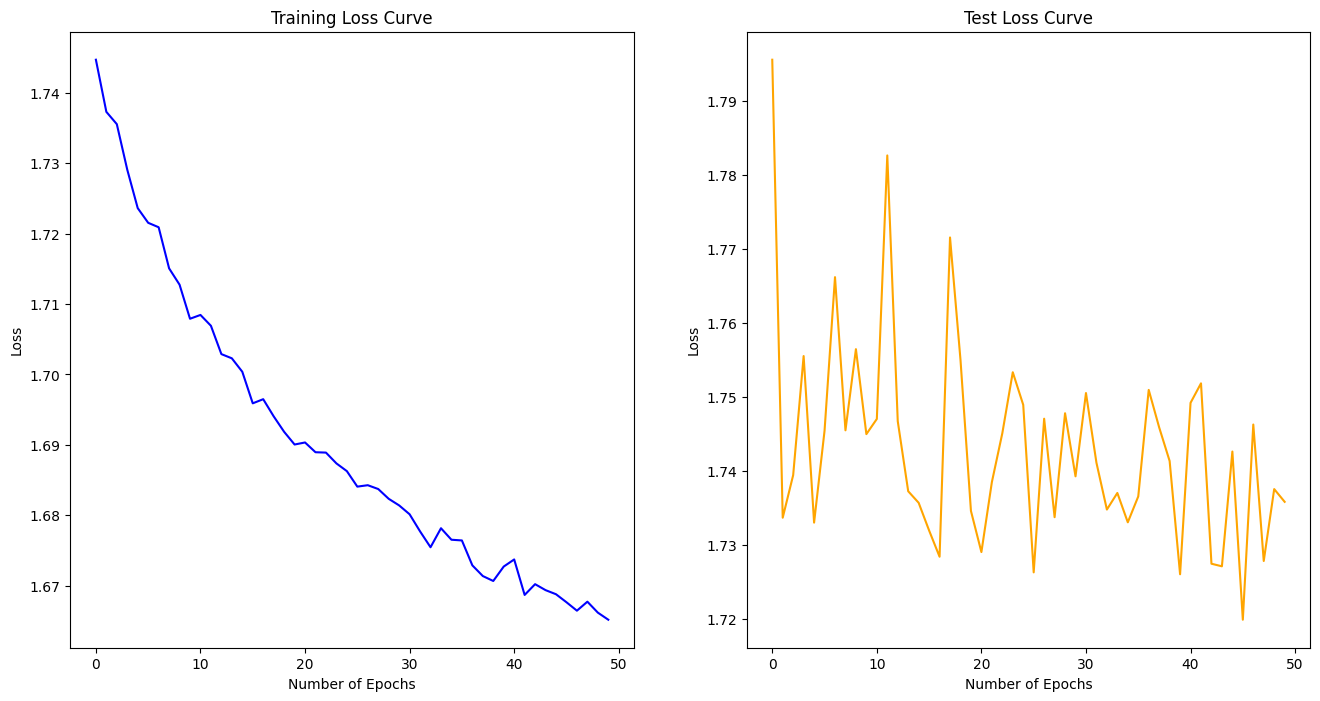

In [ ]:
plot_loss_curves(train_losses=history_0['train_losses'],
                 test_losses=history_0['test_losses'])

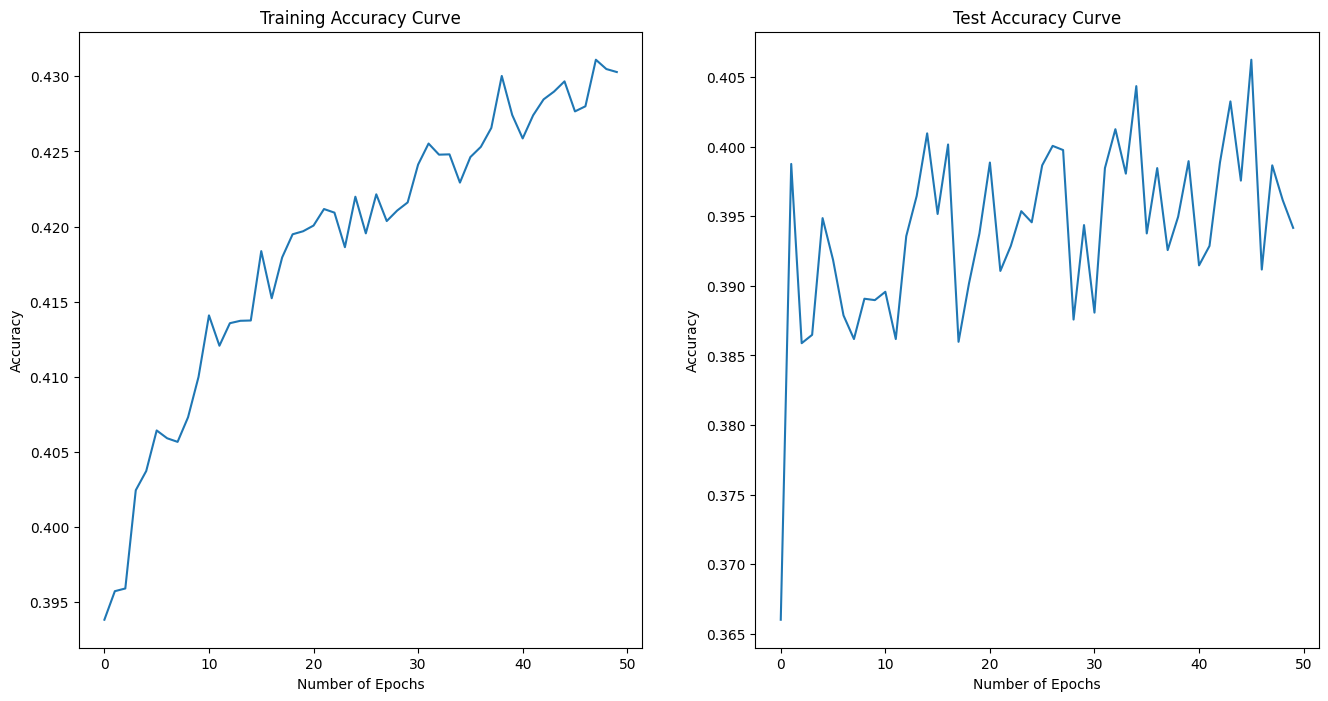

In [ ]:
plot_accuracy_curves(train_accuracies=history_0['train_accuracies'],
                     test_accuracies=history_0['test_accuracies'])

## Create a model with ReLU layers for learning non-linear patterns

In [ ]:
class CIFAR10ModelV1(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU()
    )

  def forward(self, X: torch.Tensor):
    return self.layer_stack(X)

In [ ]:
model_1 = CIFAR10ModelV1(input_shape=3*32*32,
                         output_shape=len(class_names)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=1e-3)

In [ ]:
history_1 = fit(model=model_1,
                epochs=50,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                accuracy_fn=accuracy_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

Training loss:  2.4551942348480225 | Training accuracy: 0.20795345306396484 | Test loss: 2.3024845123291016 | Test accuracy: 0.23152954876422882
Training loss:  2.262375593185425 | Training accuracy: 0.24040307104587555 | Test loss: 2.219001531600952 | Test accuracy: 0.25349441170692444
Training loss:  2.2201828956604004 | Training accuracy: 0.24416187405586243 | Test loss: 2.2068560123443604 | Test accuracy: 0.24690495431423187
Training loss:  2.1928350925445557 | Training accuracy: 0.24928022921085358 | Test loss: 2.19050931930542 | Test accuracy: 0.24321085214614868
Training loss:  2.1806750297546387 | Training accuracy: 0.24804063141345978 | Test loss: 2.1619672775268555 | Test accuracy: 0.2531948983669281
Training loss:  2.1690313816070557 | Training accuracy: 0.2453014999628067 | Test loss: 2.1487960815429688 | Test accuracy: 0.257388174533844
Training loss:  2.1628220081329346 | Training accuracy: 0.24850048124790192 | Test loss: 2.1520097255706787 | Test accuracy: 0.25159743428

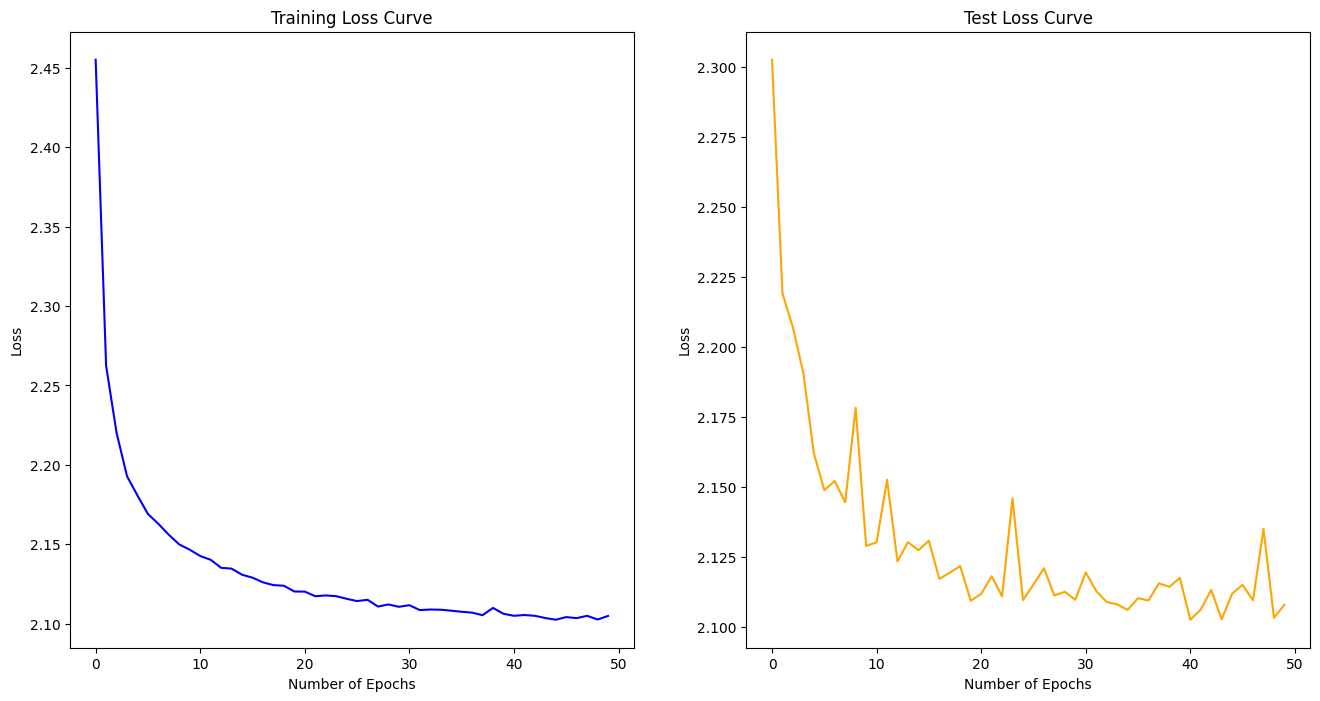

In [ ]:
plot_loss_curves(train_losses=history_1['train_losses'],
                 test_losses=history_1['test_losses'])

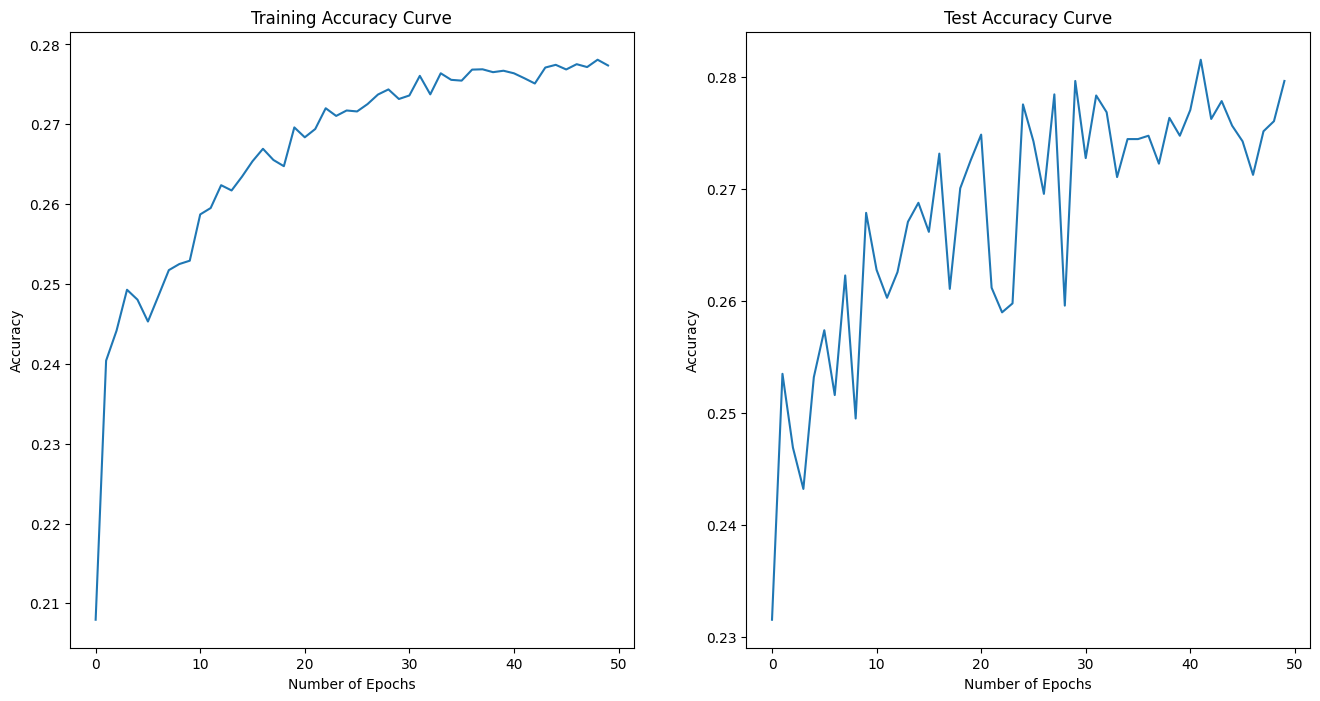

In [ ]:
plot_accuracy_curves(train_accuracies=history_1['train_accuracies'],
                     test_accuracies=history_1['test_accuracies'])

## Create a convolutional neural network

In [ ]:
class CIFAR10ModelV2(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=16,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*34*34,
                  out_features=output_shape)
    )

  def forward(self, X: torch.Tensor):
    return self.classifier(self.block_2(self.block_1(X)))

In [ ]:
model_2 = CIFAR10ModelV2(input_shape=3,
                         output_shape=10)

In [ ]:
image_tensor = torch.randn(1, 3, 32, 32)
model_2(image_tensor)

tensor([[ 0.0105, -0.0306,  0.0304,  0.0501,  0.0618, -0.0201,  0.0527, -0.0168,
          0.0547,  0.0257]], grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=1e-3)

history_2 = fit(model=model_2,
                epochs=50,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                accuracy_fn=accuracy_fn)

In [ ]:
for X, y in train_dataloader:
  print(X.shape)
  break

torch.Size([32, 3, 32, 32])


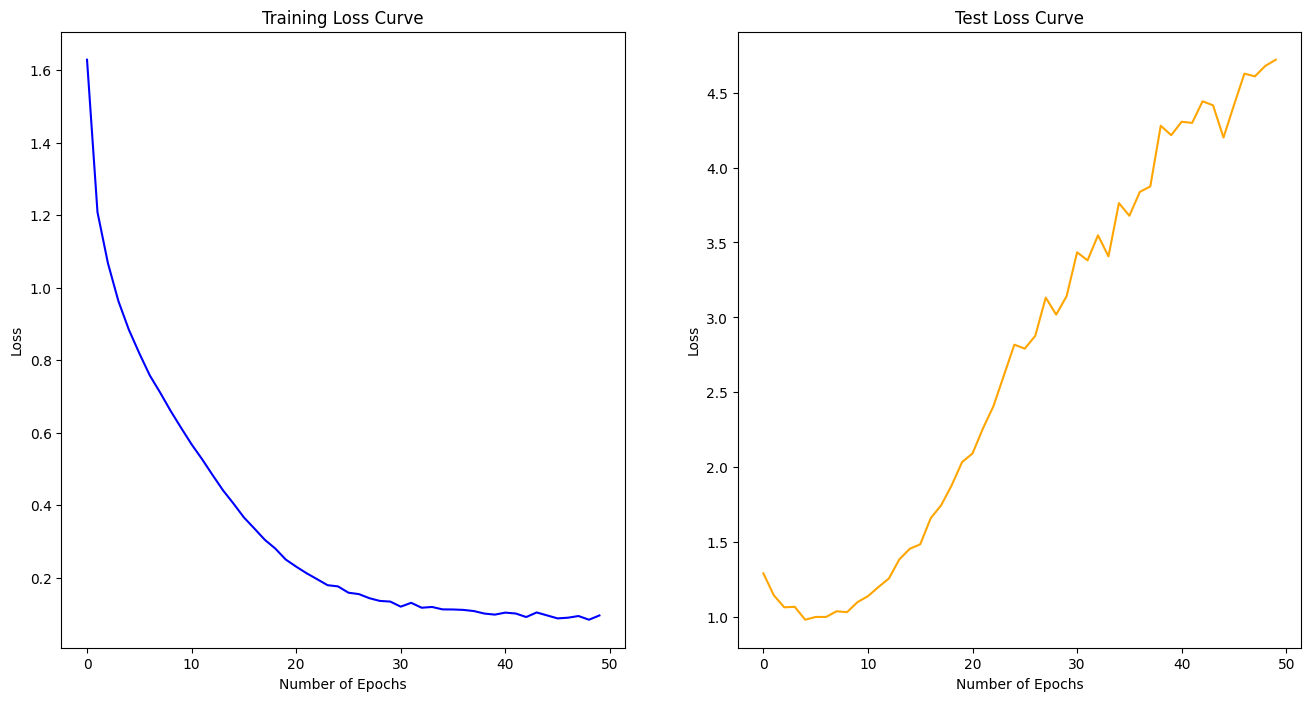

In [ ]:
plot_loss_curves(train_losses=history_2['train_losses'],
                 test_losses=history_2['test_losses'])

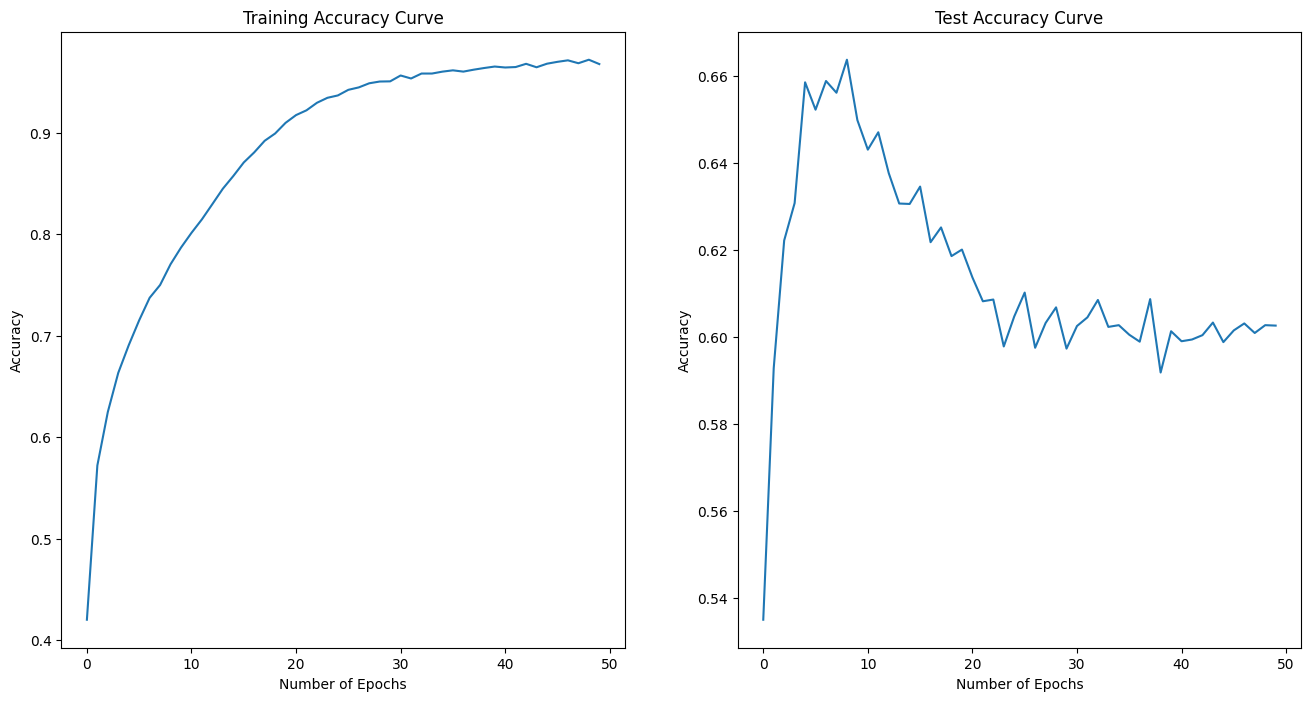

In [ ]:
plot_accuracy_curves(train_accuracies=history_2['train_accuracies'],
                     test_accuracies=history_2['test_accuracies'])

Next, let's implement early stopping into the previous model training